In [ ]:
import os
from PIL import Image

def yolo_to_ssd(yolo_label, img_width, img_height):

    class_id, center_x, center_y, width, height = map(float, yolo_label)

    xmin = int((center_x - width / 2) * img_width)
    ymin = int((center_y - height / 2) * img_height)
    xmax = int((center_x + width / 2) * img_width)
    ymax = int((center_y + height / 2) * img_height)


    return f"{xmin} {ymin} {xmax} {ymax} {int(class_id)}\n"

def convert_yolo_to_ssd(labels_dir, images_dir):
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_dir, label_file)
            image_path = os.path.join(images_dir, label_file.replace('.txt', '.png'))

            if not os.path.exists(image_path):
                print(f"Image not found for {label_file}, skipping.")
                continue

            with open(image_path, 'rb') as img_file:
                img = Image.open(img_file)
                img_width, img_height = img.size

            with open(label_path, 'r') as lf:
                yolo_labels = lf.readlines()

            ssd_labels = []
            for yolo_label in yolo_labels:
                yolo_label = yolo_label.strip().split()
                ssd_label = yolo_to_ssd(yolo_label, img_width, img_height)
                ssd_labels.append(ssd_label)

            with open(label_path, 'w') as lf:
                lf.writelines(ssd_labels)


dataset_dir = 'ssd_dataset'
subdirs = ['Train', 'Test', 'Val']

for subdir in subdirs:
    labels_dir = os.path.join(dataset_dir, subdir, 'labels')
    images_dir = os.path.join(dataset_dir, subdir, 'images')
    convert_yolo_to_ssd(labels_dir, images_dir)

print("Conversion to SSD format completed.")

Conversion to SSD format completed.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Trainyolo')

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
import cv2


class SSDDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_base = self.img_files[idx].replace('.png', '')
        label_path = os.path.join(self.label_dir, f"{label_base}.txt")

        if not os.path.exists(label_path):
            # print(f"Label file {label_path} not found. Skipping...")
            return None



        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape


        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                xmin, ymin, xmax, ymax, label = map(int, line.split())
                xmin = max(0, xmin) / w
                ymin = max(0, ymin) / h
                xmax = min(w, xmax) / w
                ymax = min(h, ymax) / h
                if 0 <= label < 8:  # Only include valid class labels
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            image = self.transform(image)

        return image, target


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return tuple(zip(*batch))


img_dir = 'ssd_dataset/Train/images'
label_dir = 'ssd_dataset/Train/labels'
train_dataset = SSDDataset(img_dir, label_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

model = ssdlite320_mobilenet_v3_large(pretrained=True)
model.num_classes = 8

model.head.classification_head.num_classes = 8


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V

In [ ]:
import torch

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()

    for batch in train_loader:
        if batch is None:
            continue

        images, targets = batch


        images = [torch.tensor(image).permute(2, 0, 1).float().to(device) for image in images]


        targets = [{k: v.clone().detach().to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {losses.item()}")

print("Training completed.")


Epoch [1/10], Loss: 7.915794372558594
Epoch [2/10], Loss: 4.137084007263184
Epoch [3/10], Loss: 7.970317840576172
Epoch [4/10], Loss: 3.926077365875244
Epoch [5/10], Loss: 5.688397407531738
Epoch [6/10], Loss: 4.913336753845215
Epoch [7/10], Loss: 4.178620338439941
Epoch [8/10], Loss: 3.387287139892578
Epoch [9/10], Loss: 2.9502460956573486
Epoch [10/10], Loss: 8.472049713134766
Training completed.


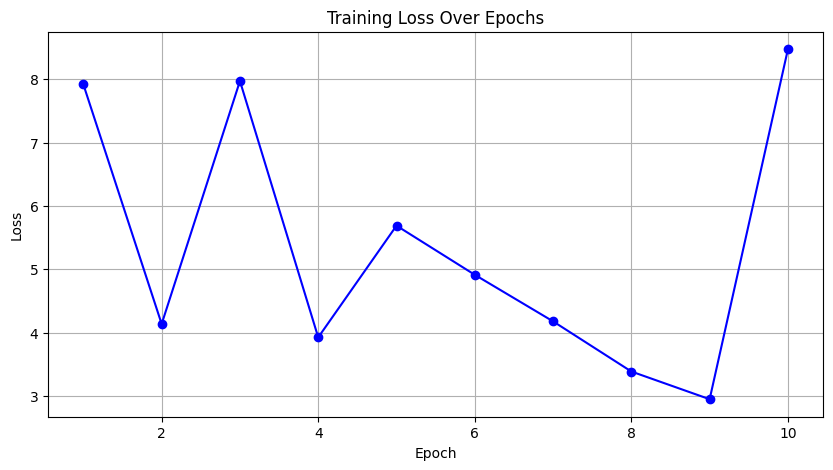

In [5]:
import matplotlib.pyplot as plt

# Loss values from each epoch
loss_values = [
    7.915794372558594,
    4.137084007263184,
    7.970317840576172,
    3.926077365875244,
    5.688397407531738,
    4.913336753845215,
    4.178620338439941,
    3.387287139892578,
    2.9502460956573486,
    8.472049713134766
]

# Number of epochs
num_epochs = len(loss_values)

# Plot the training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')
print("Training completed. Model weights saved as 'model_weights.pth'.")

Training completed. Model weights saved as 'model_weights.pth'.


In [4]:
import torch


model.load_state_dict(torch.load('model_weights1.pth', weights_only=True))

# Continue training for 10 more epochs
additional_epochs = 10
for epoch in range(additional_epochs):
    model.train()

    for batch in train_loader:
        if batch is None:
            continue

        images, targets = batch

        images = [torch.tensor(image).permute(2, 0, 1).float().to(device) for image in images]
        targets = [{k: v.clone().detach().to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{additional_epochs}], Loss: {losses.item()}")


torch.save(model.state_dict(), 'model_weights2.pth')

print("Additional training completed. Model weights saved as 'model_weights_additional.pth'.")


Epoch [1/10], Loss: 0.26617732644081116
Epoch [2/10], Loss: 2.230752944946289
Epoch [3/10], Loss: 2.7035531997680664
Epoch [4/10], Loss: 0.3750516474246979
Epoch [5/10], Loss: 2.8274500370025635
Epoch [6/10], Loss: 0.7543597221374512
Epoch [7/10], Loss: 0.5690970420837402
Epoch [8/10], Loss: 3.954561710357666
Epoch [9/10], Loss: 2.0387039184570312
Epoch [10/10], Loss: 0.5080686807632446
Additional training completed. Model weights saved as 'model_weights_additional.pth'.


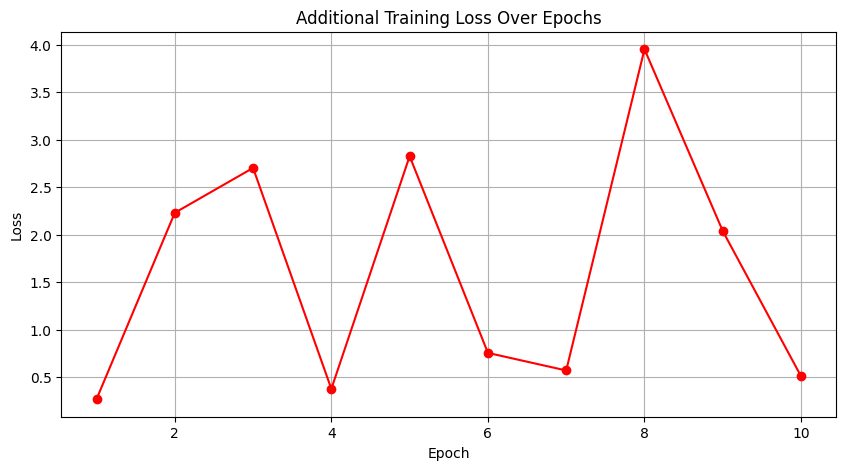

In [6]:
import matplotlib.pyplot as plt

# Loss values from additional training epochs
loss_values_additional = [
    0.26617732644081116,
    2.230752944946289,
    2.7035531997680664,
    0.3750516474246979,
    2.8274500370025635,
    0.7543597221374512,
    0.5690970420837402,
    3.954561710357666,
    2.0387039184570312,
    0.5080686807632446
]

# Number of epochs
num_epochs_additional = len(loss_values_additional)

# Plot the additional training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs_additional + 1), loss_values_additional, marker='o', linestyle='-', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Additional Training Loss Over Epochs')
plt.grid(True)
plt.show()
